In [1]:
import os
import yaml
import fsspec
import itertools

import datamol as dm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mood.rct import get_experimental_configurations
from mood.dataset import MOOD_DATASETS, MOOD_REGR_DATASETS
from mood.metrics import Metric
from mood.utils import get_outlier_bounds
from mood.model import MOOD_ALGORITHMS
from mood.representations import MOOD_REPRESENTATIONS
from mood.splitter import MOOD_SPLITTERS
from mood.criteria import MOOD_CRITERIA

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [2]:
SUBDIR = "20230112"
BASE_PATH = "gs://experiments-output/mood-v2/results/YAML/RCT/"
N_RCT_TRIALS = 250

In [3]:
def get_result_paths_for_dataset(dataset):
    pattern = dm.fs.join(BASE_PATH, SUBDIR, f"*{dataset}*.yaml")
    paths = dm.fs.glob(pattern)
    return paths


def find_missing(dataset, n: int = N_RCT_TRIALS):
    
    paths = get_result_paths_for_dataset(dataset)
    all_configs = get_experimental_configurations(dataset)[:n]
    indices = list(range(n))
    
    for path in paths: 
        
        path = dm.fs.get_basename(path)
        path = os.path.splitext(path)[0]
        
        config = path.split("_")[4:]
        config[-1] = int(config[-1])
        config = tuple(config)
        
        indices.remove(all_configs.index(config))
        
    return indices
        

for dataset in MOOD_DATASETS:
    print(f"Missing {len(find_missing(dataset))}/{N_RCT_TRIALS} of results for {dataset}")

Missing 2/250 of results for DILI
Missing 11/250 of results for HIA
Missing 7/250 of results for hERG
Missing 2/250 of results for HalfLife
Missing 3/250 of results for Caco-2
Missing 7/250 of results for Clearance
Missing 214/250 of results for Pgp
Missing 185/250 of results for PPBR
Missing 225/250 of results for BBB
Missing 227/250 of results for Lipophilicity
Missing 216/250 of results for CYP2C9


In [4]:
def load_results(path):
    with fsspec.open(path, "r") as fd:
        data = yaml.safe_load(fd)
        data.pop("hparams")
        
    # NOTE: Due to a bug, for some early workflows the seed in the YAML was faulty. 
    # Luckily, we can still extract the right seed from the filename
    if "trial_seed" not in data:
        data["trial_seed"] = data["seed"]
        data["seed"] = int(path[-6])
    
    # Add some additional information
    df = pd.DataFrame(data, index=[0])
    
    metric_cal = Metric.get_default_calibration_metric(data["dataset"])
    metric_prf = Metric.get_default_performance_metric(data["dataset"])
    
    df["metric_calibration"] = metric_cal.name
    df["metric_performance"] = metric_prf.name
    df["minimize_calibration"] = metric_cal.mode == "min"
    df["minimize_performance"] = metric_prf.mode == "min"
    
    df.columns = [col.replace(f"{metric_prf.name}_", "") for col in df.columns]
    df.columns = [col.replace(f"{metric_cal.name}_", "") for col in df.columns]
    return df


paths = [p for dataset in MOOD_DATASETS for p in get_result_paths_for_dataset(dataset)]
df_original = pd.concat(dm.utils.parallelized(load_results, paths, progress=True), ignore_index=True)
df_original.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1651/1651 [00:24<00:00, 66.89it/s]


,algorithm,criterion,criterion_final,dataset,representation,seed,test_calibration_0,test_calibration_1,test_calibration_2,test_calibration_final,...,val_extra_pearson_2,val_extra_pearson_final,val_extra_r2_0,val_extra_r2_1,val_extra_r2_2,val_extra_r2_final,val_extra_spearman_0,val_extra_spearman_1,val_extra_spearman_2,val_extra_spearman_final
0,CORAL,Performance,0.790010,DILI,ChemBERTa,2,0.339230,0.299773,0.289026,0.345597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORAL,Distance Weighted Performance,0.943881,DILI,ChemBERTa,1,0.527040,0.534507,0.520471,0.475041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORAL,Calibration,0.014632,DILI,Desc2D,6,0.021807,0.021783,0.021800,0.021807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORAL,Distance Weighted Performance,0.944334,DILI,Desc2D,3,0.285439,0.470389,0.484946,0.389334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORAL,Distance Weighted Performance,0.860807,DILI,Desc2D,1,0.457169,0.424316,0.379248,0.416898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_original.groupby("dataset")[["test_performance_final", "test_calibration_final"]].describe()

test_performance_final                                         \
                               count           mean           std       min   
dataset                                                                       
BBB                             25.0       0.707534  1.413788e-01  0.361527   
CYP2C9                          34.0       0.742172  1.198073e-01  0.478766   
Caco-2                         247.0    2438.469299  3.127997e+04  0.420418   
Clearance                      243.0   25833.264033  4.024770e+05  0.539383   
DILI                           248.0       0.677376  1.331908e-01  0.260985   
HIA                            239.0       0.714635  1.812109e-01  0.222339   
HalfLife                       248.0  332686.306804  5.165676e+06  0.099706   
Lipophilicity                   23.0       0.743527  9.215093e-02  0.513465   
PPBR                            65.0    1565.304053  1.187274e+04  0.502480   
Pgp                             36.0       0.777288  1.728296e-01  0.146832   
hERG                           243.0       0.669562  1.362509e-01  0.227858   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.616664  0.706933  0.800744  9.209718e-01   
CYP2C9         0.712419  0.772681  0.824901  8.758825e-01   
Caco-2         0.601064  0.720034  0.827228  4.825502e+05   
Clearance      0.730759  0.820298  0.874470  6.274009e+06   
DILI           0.598290  0.700073  0.775520  9.241983e-01   
HIA            0.562475  0.755080  0.865690  9.939024e-01   
HalfLife       0.200648  0.275568  0.456058  8.134646e+07   
Lipophilicity  0.666286  0.769529  0.798528  9.066825e-01   
PPBR           0.628540  0.701043  0.891129  9.563256e+04   
Pgp            0.756984  0.820204  0.858677  9.707257e-01   
hERG           0.595301  0.690781  0.770456  8.953846e-01   

              test_calibration_final                                          \
                               count      mean       std       min       25%   
dataset                                                                        
BBB                             25.0  0.428839  0.237567  0.105318  0.230243   
CYP2C9                          34.0  0.235702  0.129094  0.000000  0.160154   
Caco-2                         247.0  0.104618  0.292388 -0.401524 -0.066427   
Clearance                      243.0  0.187044  0.289452 -0.285064 -0.000801   
DILI                           247.0  0.341877  0.198773  0.000000  0.243149   
HIA                            238.0  0.523136  0.349548  0.000010  0.200530   
HalfLife                       248.0  0.225329  0.350480 -0.462056 -0.010247   
Lipophilicity                   23.0  0.064016  0.100054 -0.075144 -0.004965   
PPBR                            65.0  0.196375  0.322777 -0.342939  0.000000   
Pgp                             36.0  0.373051  0.194918  0.000000  0.249803   
hERG                           242.0  0.456896  0.255023  0.000000  0.230449   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.363589  0.661179  0.870293  
CYP2C9         0.207398  0.281889  0.532277  
Caco-2         0.037328  0.175938  0.999997  
Clearance      0.113244  0.341728  0.999990  
DILI           0.288915  0.376011  1.000000  
HIA            0.720163  0.848685  1.000000  
HalfLife       0.101189  0.432949  1.000000  
Lipophilicity  0.033769  0.124037  0.296007  
PPBR           0.091000  0.388140  0.999997  
Pgp            0.328002  0.469378  0.996586  
hERG           0.492024  0.638707  1.000000

In [6]:
df_original.groupby("dataset")[["val_performance_final", "val_calibration_final"]].describe()

val_performance_final                                         \
                              count           mean           std       min   
dataset                                                                      
BBB                            25.0       0.739136  1.695233e-01  0.271739   
CYP2C9                         34.0       0.774143  1.213104e-01  0.491182   
Caco-2                        247.0    2631.854109  3.414767e+04  0.327273   
Clearance                     243.0   54564.434252  8.503957e+05  0.481463   
DILI                          248.0       0.729547  1.637039e-01  0.170934   
HIA                           239.0       0.771829  2.001465e-01  0.012195   
HalfLife                      248.0  848581.125196  1.329904e+07  0.078272   
Lipophilicity                  23.0       0.708685  1.007202e-01  0.527608   
PPBR                           65.0    1577.043511  1.226407e+04  0.400039   
Pgp                            36.0       0.766119  2.267171e-01  0.114562   
hERG                          243.0       0.754779  1.641434e-01  0.145023   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.658225  0.771465  0.878371  9.410285e-01   
CYP2C9         0.743843  0.823145  0.864903  9.105004e-01   
Caco-2         0.589184  0.719601  0.826844  5.285675e+05   
Clearance      0.678813  0.743823  0.799612  1.325637e+07   
DILI           0.611619  0.770990  0.851344  9.956709e-01   
HIA            0.616706  0.847924  0.935021  1.000000e+00   
HalfLife       0.167399  0.206475  0.380253  2.094355e+08   
Lipophilicity  0.610364  0.730902  0.780930  9.154160e-01   
PPBR           0.570400  0.634506  0.745642  9.887194e+04   
Pgp            0.709106  0.849936  0.925402  9.907757e-01   
hERG           0.689469  0.810013  0.867408  1.000000e+00   

              val_calibration_final                                    \
                              count      mean       std           min   
dataset                                                                 
BBB                            25.0  0.436136  0.262218  6.324013e-02   
CYP2C9                         34.0  0.237494  0.136722  0.000000e+00   
Caco-2                        247.0  0.184483  0.281685 -4.687494e-01   
Clearance                     243.0  0.221312  0.289792 -2.921670e-01   
DILI                          248.0  0.353420  0.205289  0.000000e+00   
HIA                           239.0  0.517695  0.345698  1.635760e-15   
HalfLife                      248.0  0.253260  0.331140 -2.842627e-01   
Lipophilicity                  23.0  0.094875  0.113765 -5.235465e-02   
PPBR                           65.0  0.235890  0.313281 -1.795119e-01   
Pgp                            36.0  0.343938  0.192738  0.000000e+00   
hERG                          243.0  0.438650  0.234640  0.000000e+00   

                                                       
                    25%       50%       75%       max  
dataset                                                
BBB            0.206410  0.393988  0.658277  0.886969  
CYP2C9         0.169162  0.212571  0.282352  0.557866  
Caco-2         0.023337  0.126147  0.264797  1.000000  
Clearance      0.013894  0.143815  0.401841  0.999978  
DILI           0.242754  0.299965  0.409929  1.000000  
HIA            0.198184  0.663124  0.854549  1.000000  
HalfLife       0.005853  0.166062  0.448511  0.999983  
Lipophilicity  0.014619  0.064768  0.133449  0.357342  
PPBR           0.000000  0.124301  0.415100  0.999993  
Pgp            0.202625  0.397786  0.454083  0.998535  
hERG           0.238105  0.466814  0.588944  0.999590

# Comparing options

In [7]:
def clip_outliers(df, col):
    dfs = []
    for name, group in df.groupby("dataset"):
        lower, upper = get_outlier_bounds(group[col], factor=5.0)
        group[col] = group[col].clip(lower, upper)
        dfs.append(group)
    
    return pd.concat(dfs, ignore_index=True)


def diff_x_y(x, y, minimize):
    xv, yv = np.meshgrid(x, y, indexing='ij')
    xv = xv.flatten()
    yv = yv.flatten()
    
    delta = xv - yv
    if minimize:
        return -delta
    else:
        return delta


def relative_diff_for_category(data, category, for_calibration: bool):
    diffs = pd.DataFrame()
    
    if for_calibration: 
        col = "test_calibration_final"
    else:
        col = "test_performance_final"

    data = clip_outliers(data, col)
    unique = data[category].unique()
    
    for ds_name, ds_data in data.groupby("dataset"):
        
        for x, y in itertools.combinations(unique, 2):
            x_data = ds_data[ds_data[category] == x][col].to_numpy()
            y_data = ds_data[ds_data[category] == y][col].to_numpy()
            
            if len(x_data) == 0 or len(y_data) == 0:
                continue
                        
            if for_calibration:
                minimize = ds_data["minimize_calibration"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            else:
                minimize = ds_data["minimize_performance"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            
            delta1 = diff_x_y(x_data, y_data, minimize)
            delta2 = diff_x_y(y_data, x_data, minimize)

            i = len(diffs)
            df_1 = pd.DataFrame({"x": x, "y": y, "delta": delta1, "dataset": ds_name})
            df_2 = pd.DataFrame({"x": y, "y": x, "delta": delta2, "dataset": ds_name})
            diffs = pd.concat((diffs, df_1, df_2))
    
    diffs = diffs.reset_index(drop=True)
    return diffs

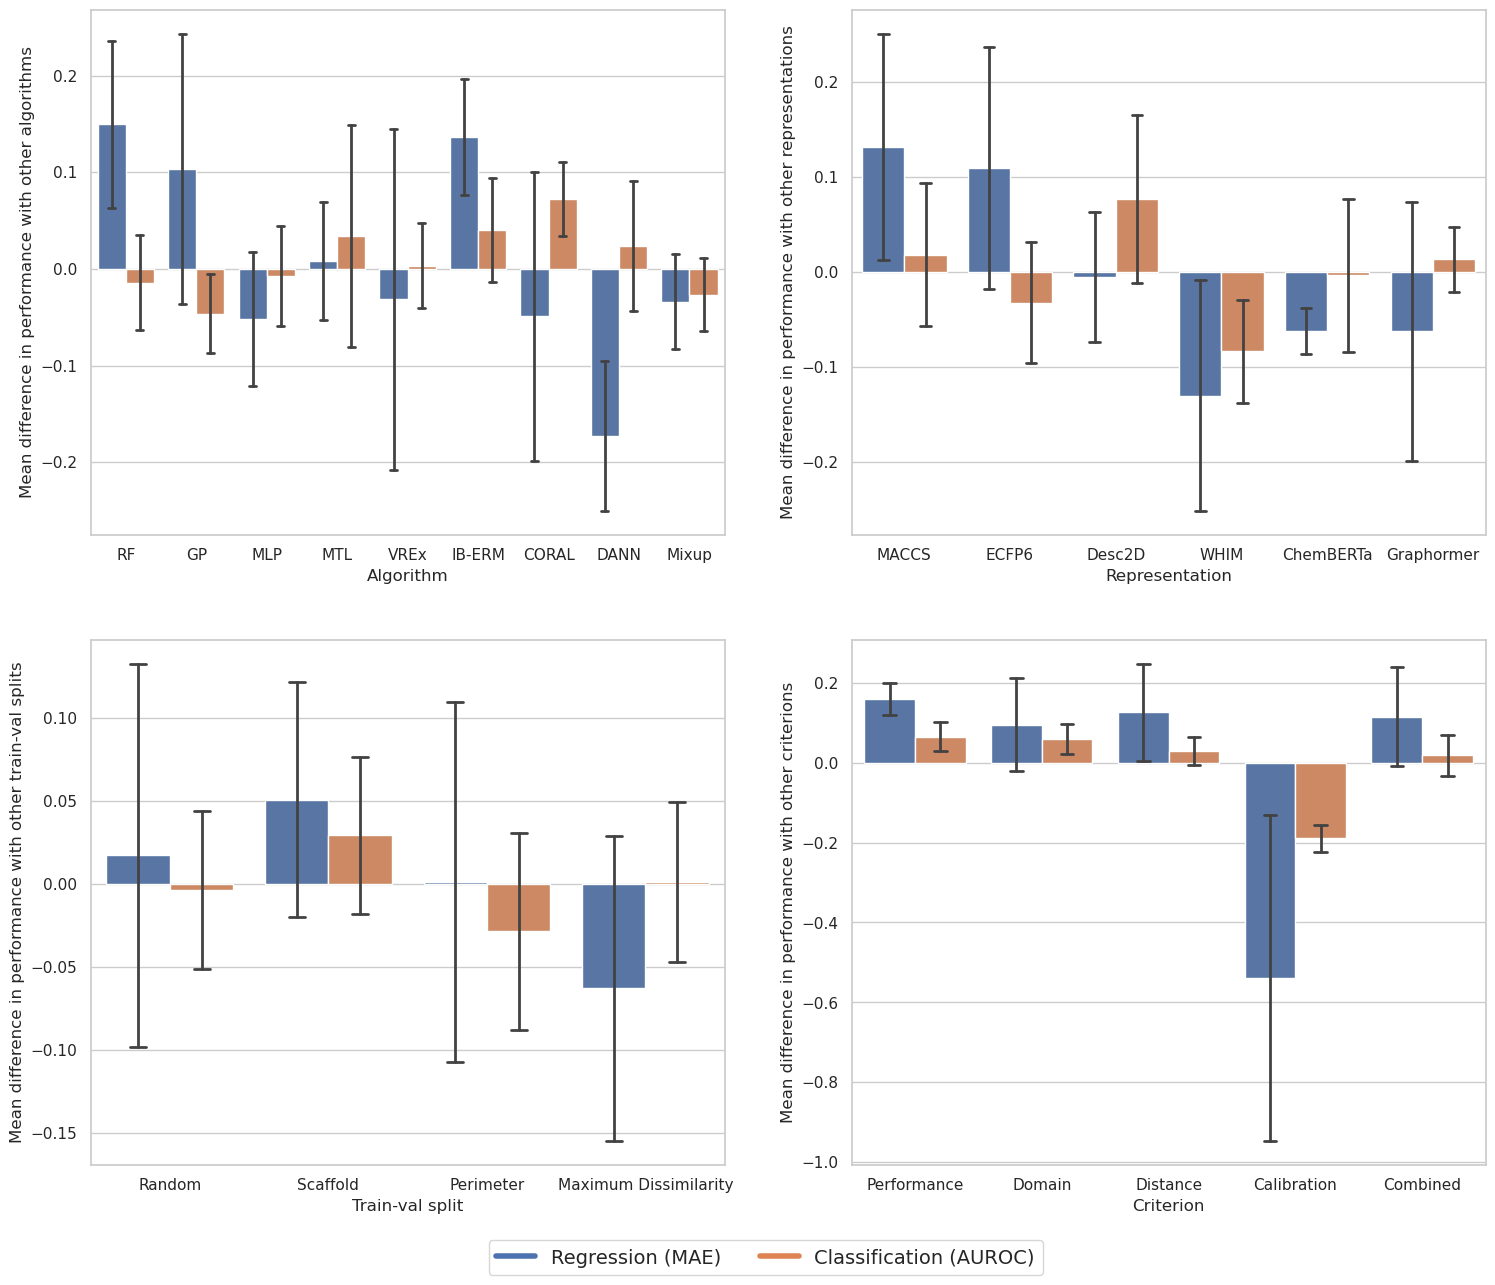

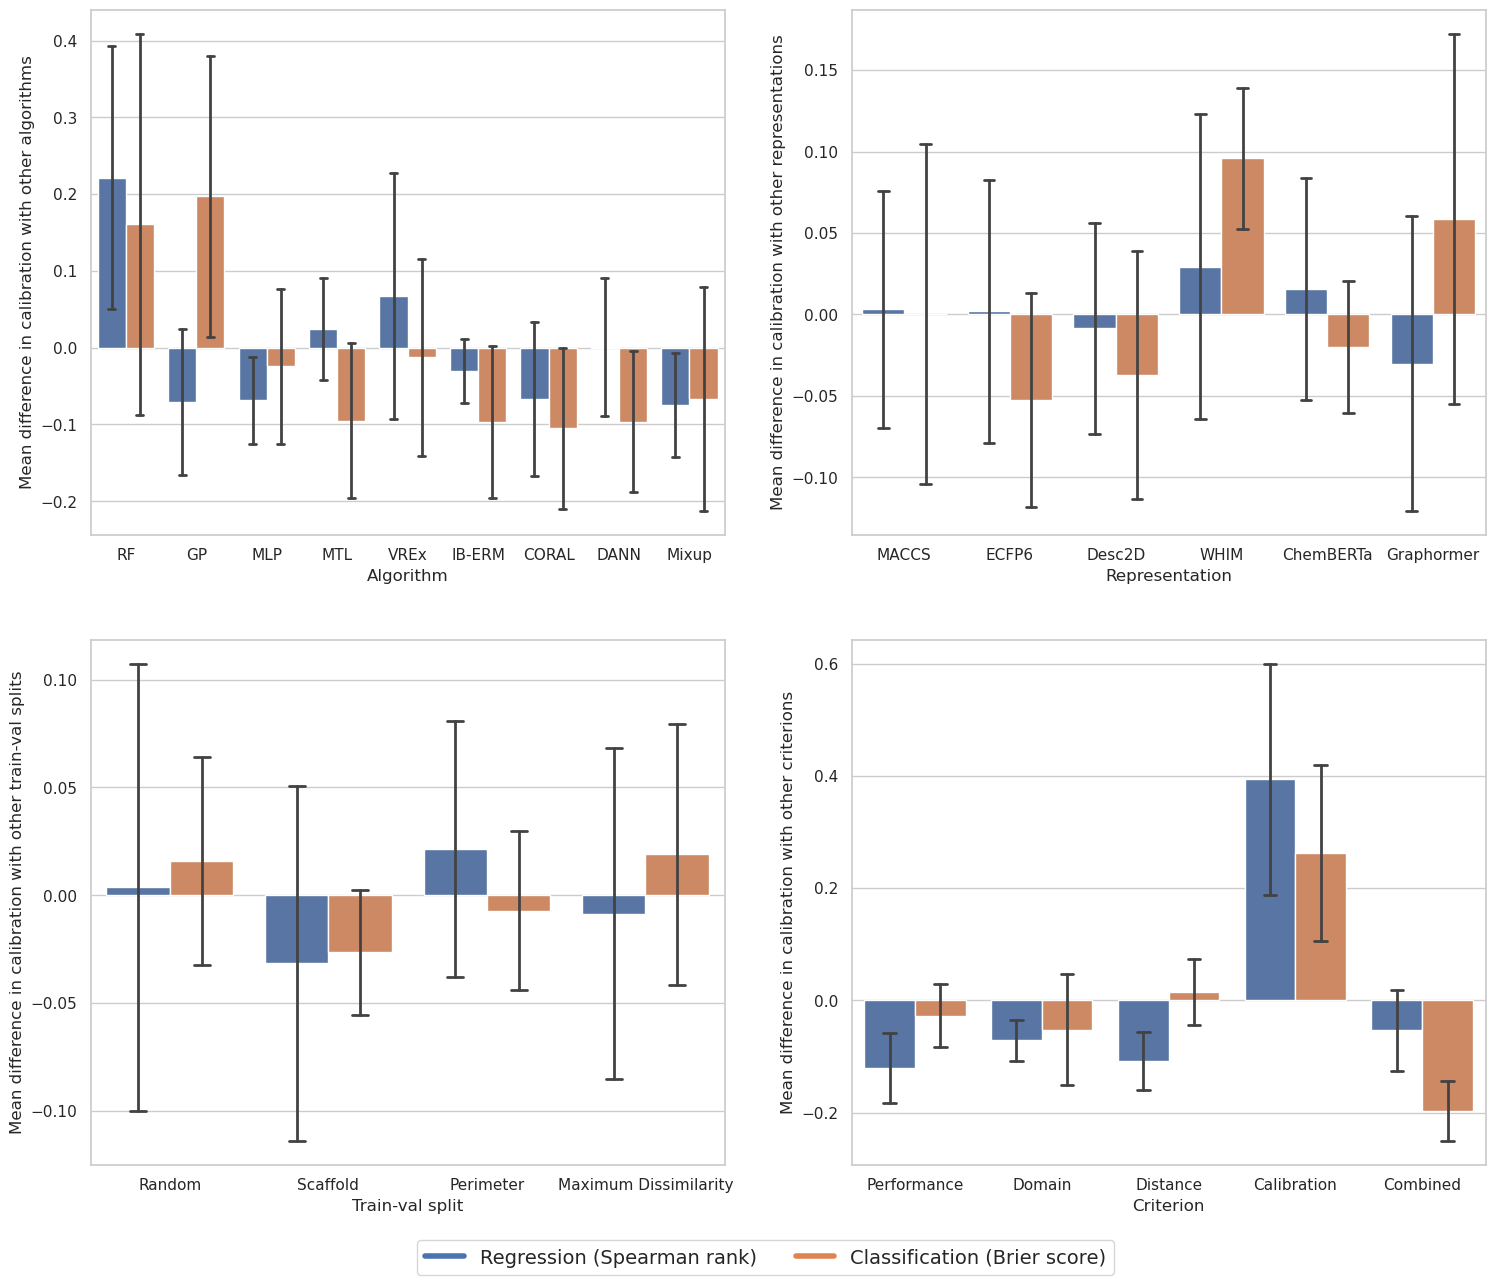

In [8]:
CAT_TO_RENAME = {
    "criterion": {
        "Domain Weighted Performance": "Domain",
        "Distance Weighted Performance": "Distance",
        "Calibration": "Calibration",
        "Performance": "Performance",
        "Calibration x Performance": "Combined"
    },
}


CAT_TO_ORDERING = {
    "algorithm": MOOD_ALGORITHMS,
    "representation": MOOD_REPRESENTATIONS,
    "criterion": MOOD_CRITERIA,
    "train_val_split": MOOD_SPLITTERS,
}

CAT_TO_TITLE = {
    "algorithm": "Algorithm",
    "representation": "Representation",
    "criterion": "Criterion",
    "train_val_split": "Train-val split",
}


def plot_single(df, category, is_calibration, ax):
    diffs = relative_diff_for_category(df, category, is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs["task_type"] =  diffs["dataset"].apply(lambda x: "regression" if x in MOOD_REGR_DATASETS else "classification")
    sns.barplot(
        data=diffs, 
        x="x", 
        y="delta", 
        errorbar="sd", 
        capsize=0.1, 
        errwidth=2, 
        ax=ax, 
        hue="task_type", 
        hue_order=["regression", "classification"], 
        order=CAT_TO_ORDERING[category]
    )
    
    rename = CAT_TO_RENAME.get(category, {})
    labels = ax.get_xticklabels()
    labels = [rename.get(label.get_text(), label.get_text()) for label in labels]
    ax.set_xticklabels(labels)
    
    ax.legend().remove()
    s = "calibration" if is_calibration else "performance"
    ax.set_ylabel(f"Mean difference in {s} with other {CAT_TO_TITLE[category].lower()}s")
    ax.set_xlabel(CAT_TO_TITLE[category])


def plot(df, is_calibration):
    df = df.copy()
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 15))
    for idx, category in enumerate(["algorithm", "representation", "train_val_split", "criterion"]):
        plot_single(df, category, is_calibration, axs[idx // 2, idx % 2])
    
    cmap = sns.color_palette()
    legend_lines = [
        plt.Line2D([0], [0], color=cmap[0], lw=4),
        plt.Line2D([0], [0], color=cmap[1], lw=4),
    ]
    
    if is_calibration:
        metrics = ("Spearman rank", "Brier score")
    else:
        metrics = ("MAE", "AUROC")

    labels = [f"{s} ({metrics[idx]})" for idx, s in enumerate(["Regression", "Classification"])]

    axs[0][0].legend(
        legend_lines,
        labels,
        fontsize=14,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.03),
        bbox_transform=plt.gcf().transFigure, 
        ncol=len(labels),
        fancybox=True
    )

    
plot(df_original, False)
plot(df_original, True)

## Comparing tools

In [9]:
def get_tool_importance(is_calibration):
    importances = {}
    for idx, category in enumerate(["algorithm", "representation", "train_val_split", "criterion", "seed"]):
        diffs = relative_diff_for_category(df_original, category, is_calibration)
        diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
        diffs = diffs.groupby("x").mean()["delta"]

        importance = diffs.max() - diffs.min()
        importances[category] = importance

    importances = {k: v / importances["seed"] for k, v in importances.items()}
    return importances

In [10]:
get_tool_importance(False)

{'algorithm': 1.1538824444049534,
 'representation': 1.390948553335858,
 'train_val_split': 0.5340000033064921,
 'criterion': 3.636834927025728,
 'seed': 1.0}

In [11]:
get_tool_importance(True)

{'algorithm': 2.972912609570168,
 'representation': 0.9977951900341752,
 'train_val_split': 0.4190974167250058,
 'criterion': 4.859599053608488,
 'seed': 1.0}

The End.